##Model 1 from the paper by Biao and Blangiardo 2006 modified by Daniel Weitzenfeld in his blog post
Orignal Paper: http://www.statistica.it/gianluca/Research/BaioBlangiardo.pdf 

Blog Post: http://danielweitzenfeld.github.io/passtheroc/blog/2014/10/28/bayes-premier-league/

###Model Specification

Number of goals scored by home team in game g is denoted by $y_{home}^{(g)}$. The number of goals scored by the away team in game g is denoted by $y_{away}^{(g)}$. The $y$'s are assumed to follow a Poisson distribution with an unknown rate parameter.

$$ y_{home} | \theta_{home} \sim Poisson(\theta_{home}) $$

$$ y_{away} | \theta_{away} \sim Poisson(\theta_{away}) $$

The rate parameter is assumed to depend on some underlying ability of each time. In the definitions below $h(g)$ denotes the home team for game g and $a(g)$ denotes the away team.

$$ log (\theta_{home}) = home + intercept + att_{h(g)} + def_{a(g)} $$

$$ log  (\theta_{away}) = intercept + att_{a(g)} + def_{h(g)} $$


The $att_t$ and $def_t$ for each team are assumed to be drawn from a normal distribution with mean 0. $\tau$ here represents precision

$$ att_t \sim N(0,1 / \tau_{att}) $$
$$ def_f \sim N(0,1 / \tau_{def}) $$

The model defines non-informative hyper priors on $\tau$, $home$ and $intercept$

$$ \tau_{att} \sim Gamma(0.1,0.1) $$
$$ \tau_{def} \sim Beta(0.1,0.1) $$


$$ home \sim N(0,1000) $$
$$ intercept \sim N(0,1000) $$


The model also constraints the $att_t$ and $def_t$ to sum to 0.

$$ \sum_t att_t = 0 $$

$$ \sum_t def_t = 0 $$


###Our Updates (using ideas inspired by Biao / Blangiardo Model 2):

The intercept term here represents the mean scoring ability of each team. But we don't believe the mean scoring ability is the same for all teams. So we modify the model to incorporate this prior knowledge. We split teams into $k$ classes based on their position in the league table last year, their total payroll or some such measure. For now, I use their position in the table last year and split the table in $k$ = 3 groups: top third, middle third and bottom third. 

The intercept for each of these $k$ groups is allowed to differ in our new model. Let $c(t)$ be the function that maps a team $t$ to it's class as defined above. Then we change

$$ log (\theta_{home}) = home + intercept_{c(h(g))} + att_{h(g)} + def_{a(g)} $$

$$ log  (\theta_{away}) = intercept_{c(a(g))} + att_{a(g)} + def_{h(g)} $$

and each of the $k$ intercepts are

$$ intercept_m \sim N(0,1000) $$



###Code

We first import the necessary libraries

In [1]:
%matplotlib inline
import os
import math
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc
import urllib2
import pymc.graph as pymcgr
from IPython.display import Image
import datetime

Couldn't import dot_parser, loading of dot files will not be possible.


###Fucntions to retreive data and make tables
Next we write some generic functions that will get the data for the relevant year from the football data website and clean it to be in the format we need. We get rid of the many columns in there that relate to betting


In [2]:
## this is where all the helper funcitons are stored
import messy
reload(messy)

<module 'messy' from 'messy.pyc'>

###Get the data and create classification
Now we actually get the data we want.

In [3]:
# define the years you want to get the data for
year_c = "1415"
year_p = "1314"
league = "E0"

# get data
data_c = messy.get_data(year_c,league)
teams, matches_c = messy.clean_data(data_c)

# get data for the target year
data_c = messy.get_data(year_c,league)
teams, matches_c = messy.clean_data(data_c)

# get data for the previous year
# for now this is how we're binning teams into classes
data_p = messy.get_data(year_p,league)
teams_p, matches_p = messy.clean_data(data_p,add_outcomes=True)

# create season table for the previous year
season_tbl_p = messy.create_season_table(matches_p,teams_p)

# classify teams into groups based on their finish the previous season
num_classes = 3

# get the rank and merge into the main table
ranking = season_tbl_p[['team','position']].copy()
ranking['class'] =  np.repeat(np.arange(num_classes),len(ranking.team)/num_classes +1)[:len(ranking.team)]
ranking = ranking.drop('position',axis=1)

# merge with current data to get previous ranking
teams = pd.merge(teams,ranking,how='left',left_on='team',right_on='team')
teams.loc[teams['class'].isnull(),'class'] = num_classes - 1

###Set up variables needed for the model

We now set up the variables that will be used to build the model. We need to go from pandas dataframes to numpy arrays.

In [4]:
# these variables are used in the modelling.
observed_home_goals = matches_c.home_goals.values
observed_away_goals = matches_c.away_goals.values
home_team = matches_c.i_home.values
away_team = matches_c.i_away.values
team_class = np.array(teams['class'].values,dtype='int')
num_teams = len(matches_c.i_home.unique())
num_games = len(home_team)

# this is not necessarily needed but it improves performance
g = matches_c.groupby('i_away')
att_starting_points = np.log(g.away_goals.mean())
g = matches_c.groupby('i_home')
def_starting_points = -np.log(g.away_goals.mean())


###Model Setup
Here we set up the actual model using pymc 

In [5]:
#hyperpriors
home = pymc.Normal('home', 0, .0001, value=0)
tau_att = pymc.Gamma('tau_att', .1, .1, value=10)
tau_def = pymc.Gamma('tau_def', .1, .1, value=10)

# one intercept per class of team
intercept_star = pymc.Normal('intercept_star', 0, .0001, value=np.zeros(num_classes), size=num_classes)

# trick to code classes of intercepts
@pymc.deterministic
def intercept(intercept_star=intercept_star,team_class=team_class):
    intercept_c = intercept_star.copy()
    return intercept_c[team_class]


#team-specific parameters
atts_star = pymc.Normal("atts_star", 
                        mu=0, 
                        tau=tau_att, 
                        size=num_teams, 
                        value=att_starting_points.values)
defs_star = pymc.Normal("defs_star", 
                        mu=0, 
                        tau=tau_def, 
                        size=num_teams, 
                        value=def_starting_points.values) 

# trick to code the sum to zero contraint
@pymc.deterministic
def atts(atts_star=atts_star):
    atts = atts_star.copy()
    atts = atts - np.mean(atts_star)
    return atts

@pymc.deterministic
def defs(defs_star=defs_star):
    defs = defs_star.copy()
    defs = defs - np.mean(defs_star)
    return defs

# home scoring parameter and away scoring parameter
@pymc.deterministic
def home_theta(home_team=home_team, 
               away_team=away_team, 
               home=home, 
               atts=atts, 
               defs=defs, 
               intercept=intercept): 
    return np.exp(intercept[home_team] + 
                  home + 
                  atts[home_team] + 
                  defs[away_team])
  
@pymc.deterministic
def away_theta(home_team=home_team, 
               away_team=away_team, 
               home=home, 
               atts=atts, 
               defs=defs, 
               intercept=intercept): 
    return np.exp(intercept[away_team] + 
                  atts[away_team] + 
                  defs[home_team])   

# number of goals scored by each time
home_goals = pymc.Poisson('home_goals', 
                          mu=home_theta, 
                          value=observed_home_goals, 
                          observed=True)
away_goals = pymc.Poisson('away_goals', 
                          mu=away_theta, 
                          value=observed_away_goals, 
                          observed=True)

## set up the full model
mcmc = pymc.MCMC([home, intercept_star, intercept, 
                  tau_att, tau_def, 
                  home_theta, away_theta, 
                  atts_star, defs_star, atts, defs, 
                  home_goals, away_goals])

## run the actual MCMC sampling for all our variables
mcmc.sample(200000, 40000, 50)

 [-----------------100%-----------------] 200000 of 200000 complete in 137.5 sec

###Check convergence
It's important to check convergence in these models

Plotting intercept_star_0
Plotting intercept_star_1
Plotting intercept_star_2


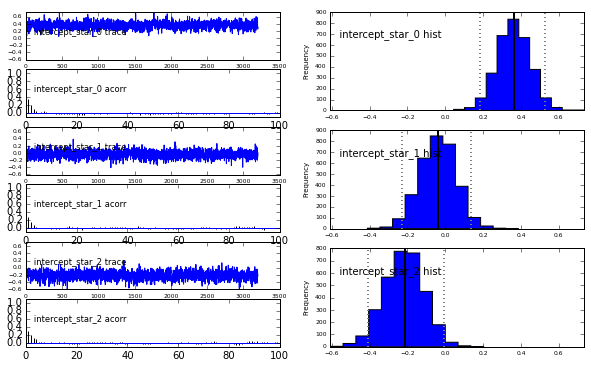

In [6]:
# Check if the intercept is actually producing differnt means for the different classes
pymc.Matplot.plot(intercept_star,path="../Figures/")

####Intercept
We do see a significant difference in the mean scoring ability of the top teams relative to the middle and bottom teams.

The convergence plots look ok. There's some autocorrelation and perhaps we need to increase the thinning to get rid of this. 


###$\tau_{att}$
This looks like it has converged

Plotting tau_att


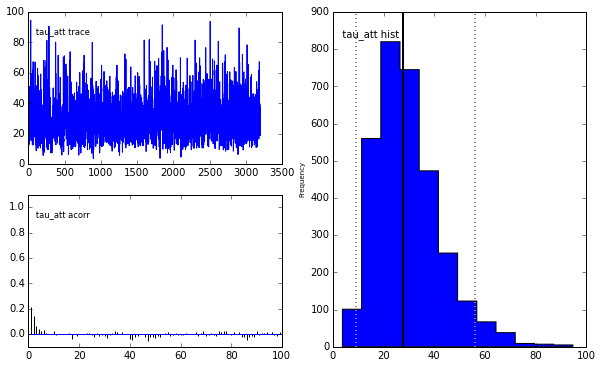

In [7]:
pymc.Matplot.plot(tau_att,path="../Figures/")


###$\tau_{def}$
This looks like it has converged

Plotting tau_def


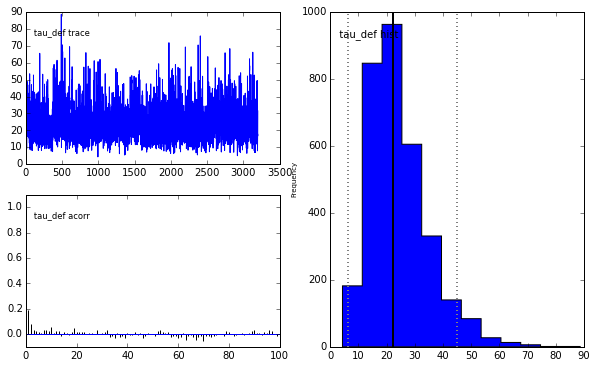

In [8]:
pymc.Matplot.plot(tau_def,path="../Figures/")

###Check Model Hierarchy

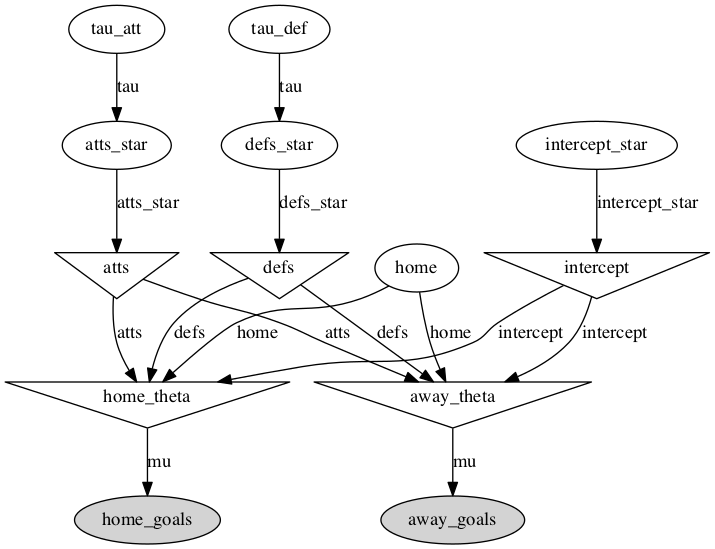

In [9]:
## Here we display the model we created to ensure that it agrees with the model we had set out to create
model_graph = pymcgr.graph(mcmc)
Image(model_graph.create_png())

###Testing
Now we try to test (first in-sample) as to how out model works. We simulate draws from our model and simulate an entire season. We then see how this compares to the real outcomes

In [10]:
simuls = messy.simulate_seasons(matches_c,teams,atts,defs,home,intercept,100)
g = simuls.groupby('team')
season_hdis = pd.DataFrame({'goals_for_lower': g.gf.quantile(.05),
                            'goals_for_median': g.gf.median(),
                            'goals_for_upper': g.gf.quantile(.95),
                            })

obs_season = messy.create_season_table(matches_c,teams)


###Plots of Simulation
We now plot the results of our simulation vs the observed data

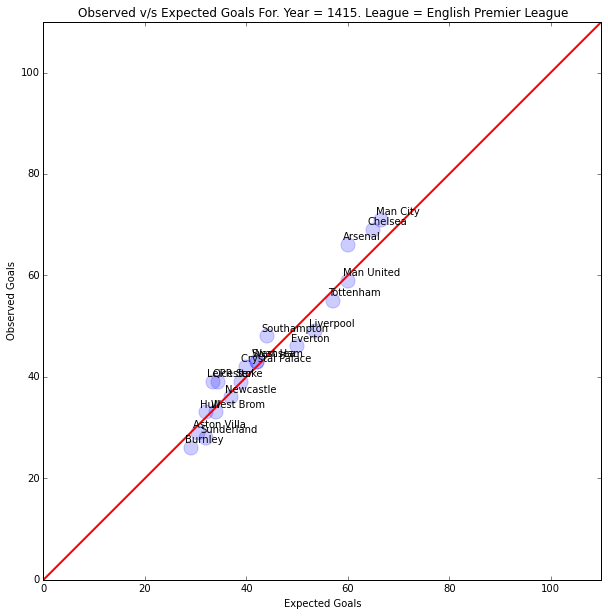

In [11]:
# merge the observed and the simulated data
model_comp = pd.merge(obs_season[["team","gf"]],season_hdis,left_on="team",right_index=True)

# new figure
plt.figure(figsize=(10,10))

# plot the goals scored
plt.scatter(model_comp.goals_for_median.values,model_comp.gf.values,color="blue",s=200,alpha=0.2)

# plot the 45 degree line so we can get a sense for how good the fit is
plt.plot([0,110],[0,110],color="red",lw=2)

# annotate with the name of the club
for t,x,y in zip(model_comp.team.values,model_comp.goals_for_median.values,model_comp.gf.values):
    plt.annotate(t, xy=(x,y), xytext = (-5,5), textcoords = 'offset points')

plt.xlabel("Expected Goals")
plt.ylabel("Observed Goals")
plt.xlim((0,110))
plt.ylim((0,110))
plt.title("Observed v/s Expected Goals For. Year = " + year_c + ". League = " + messy.leagues[league],fontsize="large")
plt.savefig("../Figures/obsVSexpGoals"+year_c+league+".png",format="png")

###Relative Strengths of Teams
Now we plot the relative strengths of each time against each other. The y axis is each team's attacking stength (higher is better) and the x axis is their defensive strength (lower is better). The plot also shows the mean goal scoring ability of the team depending on the group to which it belongs.

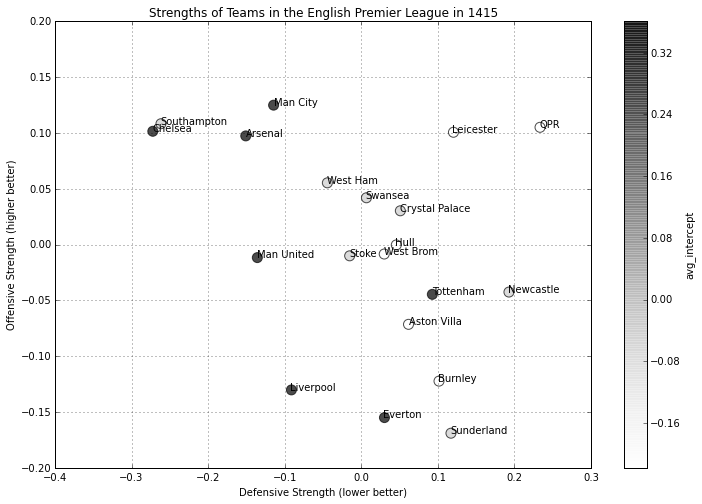

In [12]:
# get team parameters
team_params = messy.create_team_param_table(teams,atts,defs,home,intercept)

# plot
ax = team_params.plot("avg_def","avg_att",kind="scatter",figsize=(12,8),alpha=0.7,s=100,c="avg_intercept")

# annotate
for t,x,y in zip(team_params.team,team_params.avg_def,team_params.avg_att):
    ax.annotate(t,xy=(x,y))

plt.xlabel("Defensive Strength (lower better)")
plt.ylabel("Offensive Strength (higher better)")
plt.title("Strengths of Teams in the "+messy.leagues[league]+" in "+year_c)
plt.savefig("../Figures/relStrength"+year_c+league+".png",format="png")


###Forecast for Next Week
Now that we have a well fitting model for the data we can use it to forecast next weekend's games. So lets do that!!

In [13]:
# run forecasts for EPL only
if league == "E0" and year_c == "1415":
    ## Get upcoming games list
    fixtures = messy.get_epl_fixtures()

    ## Get the games for next weekend
    nextMatchDate = min(fixtures['Date'][fixtures['Date'] > datetime.date.today()])
    fixtures = fixtures[fixtures['Date'] == nextMatchDate]
    print nextMatchDate

    ## add indices to the fixtures
    fixtures = pd.merge(fixtures,teams,left_on='home',right_on='team')
    fixtures.drop('class',axis=1,inplace=True)
    fixtures.drop('team',axis=1,inplace=True)
    fixtures = fixtures.rename(columns={'i':'home_i'})
    fixtures = pd.merge(fixtures,teams,left_on='away',right_on='team')
    fixtures.drop('class',axis=1,inplace=True)
    fixtures.drop('team',axis=1,inplace=True)
    fixtures = fixtures.rename(columns={'i':'away_i'})

    # simulate results
    pred_results = messy.simulate_matches(fixtures,atts,defs,home,intercept)

2015-05-09 00:00:00


In [17]:
pred_results[['home','away','p_home_win','p_away_win','p_draw','mean_home_goals','mean_away_goals']]

,home,away,p_home_win,p_away_win,p_draw,mean_home_goals,mean_away_goals
0,Arsenal,Swansea,0.634,0.157,0.209,2.117,0.900
1,Aston Villa,West Ham,0.316,0.412,0.272,0.963,1.161
2,Chelsea,Liverpool,0.605,0.183,0.212,1.931,0.960
3,Crystal Palace,Man United,0.289,0.453,0.258,1.110,1.486
4,Everton,Sunderland,0.588,0.178,0.234,1.838,0.868
5,Hull,Burnley,0.455,0.237,0.308,1.178,0.767
6,Leicester,Southampton,0.277,0.440,0.283,0.888,1.216
7,Man City,QPR,0.779,0.094,0.127,2.770,0.769
8,Newcastle,West Brom,0.418,0.304,0.278,1.247,1.026
9,Stoke,Tottenham,0.379,0.358,0.263,1.374,1.309


In [15]:
reload(messy)

<module 'messy' from 'messy.pyc'>

In [22]:
## naive model

obs_season_p = messy.create_season_table(matches_p,teams_p)[["team","gf","ga"]]
obs_season_p = obs_season_p.rename(columns={"gf":"gf_p","ga":"ga_p"})
obs_season_f = pd.merge(obs_season,obs_season_p)
obs_season_f["gf_p"] = 35./38. * obs_season_f[["gf_p"]]
obs_season_f[["team","gf","gf_p"]]




,team,gf,gf_p
0,Chelsea,69,65.394737
1,Arsenal,66,62.631579
2,Man City,71,93.947368
3,Man United,59,58.947368
4,Liverpool,49,93.026316
5,Tottenham,55,50.657895
6,Southampton,48,49.736842
7,Swansea,43,49.736842
8,West Ham,43,36.842105
9,Stoke,39,41.447368


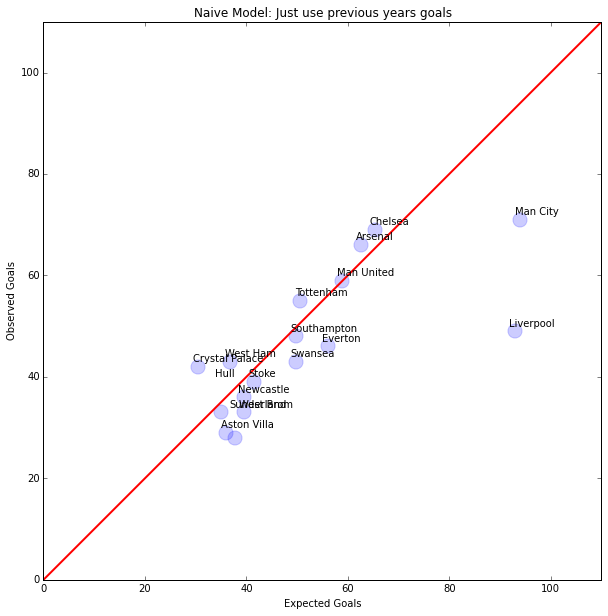

In [24]:
# new figure
plt.figure(figsize=(10,10))

# plot the goals scored
plt.scatter(obs_season_f.gf_p.values,obs_season_f.gf.values,color="blue",s=200,alpha=0.2)

# plot the 45 degree line so we can get a sense for how good the fit is
plt.plot([0,110],[0,110],color="red",lw=2)

# annotate with the name of the club
for t,x,y in zip(obs_season_f.team.values,obs_season_f.gf_p.values,model_comp.gf.values):
    plt.annotate(t, xy=(x,y), xytext = (-5,5), textcoords = 'offset points')

plt.xlabel("Expected Goals")
plt.ylabel("Observed Goals")
plt.xlim((0,110))
plt.ylim((0,110))
plt.title("Naive Model: Just use previous years goals")